In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [157]:
df=pd.read_csv('NSEI.csv')

In [158]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,26-Dec-25,"26,121.25","26,144.20","26,008.60","26,042.30","26,042.30",-
1,24-Dec-25,"26,170.65","26,236.40","26,123.00","26,142.10","26,142.10","188,800"
2,23-Dec-25,"26,205.20","26,233.55","26,119.05","26,177.15","26,177.15","216,600"
3,22-Dec-25,"26,055.85","26,180.70","26,047.80","26,172.40","26,172.40","253,000"
4,19-Dec-25,"25,911.50","25,993.35","25,880.45","25,966.40","25,966.40","382,900"
...,...,...,...,...,...,...,...
1232,01-Jan-21,"13,996.10","14,049.85","13,991.35","14,018.50","14,018.50","358,100"
1233,31-Dec-20,"13,970.00","14,024.85","13,936.45","13,981.75","13,981.75","452,400"
1234,30-Dec-20,"13,980.90","13,997.00","13,864.95","13,981.95","13,981.95","380,700"
1235,29-Dec-20,"13,910.35","13,967.60","13,859.90","13,932.60","13,932.60","439,600"


In [159]:
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1237 non-null   object
 1   Open        1237 non-null   object
 2   High        1237 non-null   object
 3   Low         1237 non-null   object
 4   Close       1237 non-null   object
 5   Adj Close   1237 non-null   object
 6   Volume      1237 non-null   object
dtypes: object(7)
memory usage: 67.8+ KB


Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
dtype: int64

In [160]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df = df.sort_values('Date')
df.reset_index(drop=True, inplace=True)

In [161]:
df.columns = df.columns.str.strip()

In [162]:
df = df[['Date','Adj Close']]
df.rename(columns={'Adj Close':'Price'}, inplace=True)

In [163]:
df.columns

Index(['Date', 'Price'], dtype='object')

In [164]:
df.dtypes
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [165]:
df['Return'] = df['Price'].pct_change()
df.dropna(inplace=True)

In [166]:
df.columns

Index(['Date', 'Price', 'Return'], dtype='object')

In [167]:
df['Volatility'] = df['Return'].rolling(window=21).std()
df.dropna(inplace=True)

In [168]:
df['Return_lag1'] = df['Return'].shift(1)
df['Return_lag2'] = df['Return'].shift(2)
df['MA_5'] = df['Return'].rolling(5).mean()
df['MA_10'] = df['Return'].rolling(10).mean()
df['Vol_lag1'] = df['Volatility'].shift(1)
df.dropna(inplace=True)

In [169]:
split = int(0.8 * len(df))
train = df.iloc[:split]
test = df.iloc[split:]
X_train = train[['Return_lag1','Return_lag2','MA_5','MA_10','Vol_lag1']]
y_train = train['Volatility']
X_test = test[['Return_lag1','Return_lag2','MA_5','MA_10','Vol_lag1']]
y_test = test['Volatility']

In [170]:
print(X_train.shape, X_test.shape)

(965, 5) (242, 5)


In [171]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

rf.fit(X_train, y_train)
predicted_vol = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_vol))
print("Volatility RMSE:", rmse)


Volatility RMSE: 0.0004574681497566113


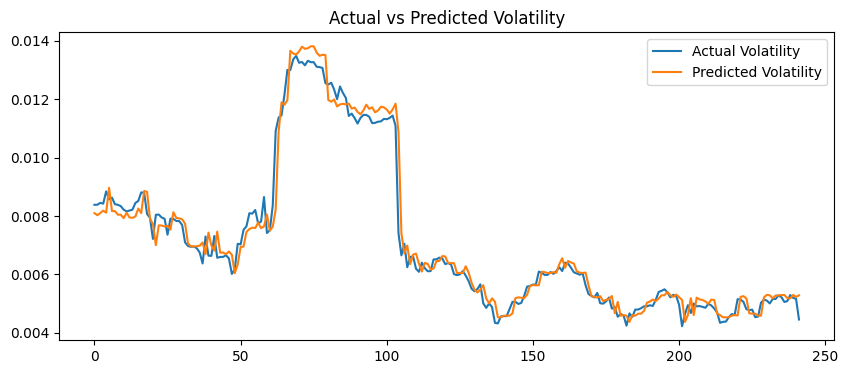

In [172]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label='Actual Volatility')
plt.plot(predicted_vol, label='Predicted Volatility')
plt.legend()
plt.title("Actual vs Predicted Volatility")
plt.show()

In [173]:
from scipy.stats import t

def monte_carlo_var_t(returns, sigma, sims=5000, alpha=0.99, df=5):
    mu = returns.mean()
    simulated_returns = t.rvs(df, loc=mu, scale=sigma, size=sims)
    return -np.percentile(simulated_returns, (1 - alpha) * 100)



In [174]:
value_at_risk_99 = []

in_sample_returns = train['Return']

for sigma in predicted_vol:
    var = monte_carlo_var(in_sample_returns, sigma)
    value_at_risk_99.append(var)


In [175]:
len(value_at_risk_99), len(predicted_vol)

(242, 242)

In [176]:
actual_losses = -test['Return'].values[:len(value_at_risk_99)]
violations = actual_losses > value_at_risk_99

print("Total observations:", len(violations))
print("VaR violations:", violations.sum())
print("Violation %:", violations.mean() * 100)


Total observations: 242
VaR violations: 2
Violation %: 0.8264462809917356


In [177]:
from scipy.stats import binomtest

x = violations.sum()
T = len(violations)

binom_p = binomtest(x, T, 0.01).pvalue
print("Binomial test p-value:", binom_p)


Binomial test p-value: 1.0


In [178]:
historical_var_99 = -np.percentile(train['Return'], 1)
print("Historical 99% VaR:", historical_var_99)


Historical 99% VaR: 0.024553831235931318


In [179]:
historical_losses = -test['Return']
historical_violations = historical_losses > historical_var_99
print("Historical VaR violation %:",
      historical_violations.mean() * 100)


Historical VaR violation %: 0.4132231404958678


In [180]:
from scipy.stats import binomtest
x_hist = historical_violations.sum()
T_hist = len(historical_violations)
binom_hist = binomtest(x_hist, T_hist, 0.01)
print("Historical VaR binomial p-value:", binom_hist.pvalue)


Historical VaR binomial p-value: 0.7386339850021495


In [181]:
print("FINAL VAR COMPARISON (99%)")
print("Historical VaR violation % :", historical_violations.mean() * 100)
print("ML Monte Carlo VaR violation % :", violations.mean() * 100)


FINAL VAR COMPARISON (99%)
Historical VaR violation % : 0.4132231404958678
ML Monte Carlo VaR violation % : 0.8264462809917356


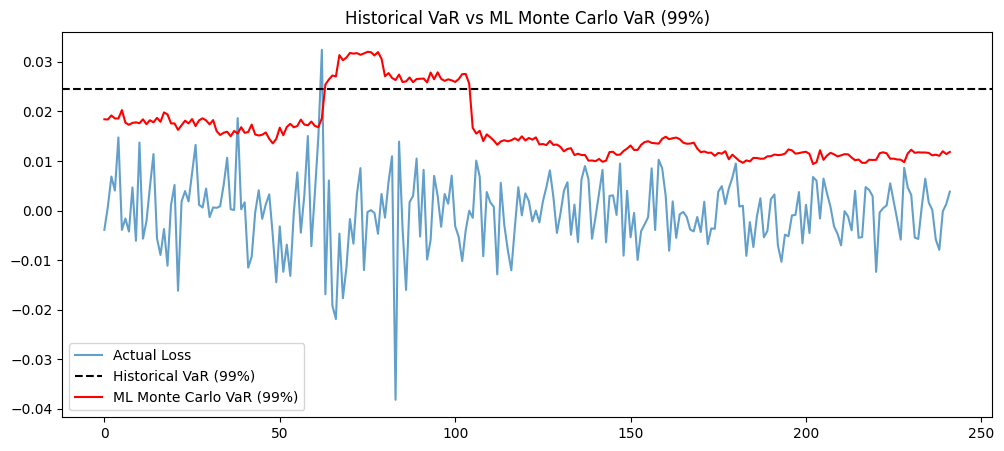

In [182]:
plt.figure(figsize=(12,5))
plt.plot(-test['Return'].values, label='Actual Loss', alpha=0.7)
plt.axhline(historical_var_99,linestyle='--',color='black',label='Historical VaR (99%)')
plt.plot(value_at_risk_99,color='red',label='ML Monte Carlo VaR (99%)')
plt.legend()
plt.title("Historical VaR vs ML Monte Carlo VaR (99%)")
plt.show()
